# Predicción de Ictus: Selección y Optimización del Modelo

Este notebook documenta el proceso completo de análisis, experimentación y justificación para la elección del mejor modelo predictivo en el contexto del riesgo de **ictus**.

**Dataset final**: `brain_s.csv` (combinación enriquecida de datos para mejorar la calidad del aprendizaje).

**Modelo elegido**: `RandomForestClassifier` + `RandomUnderSampler` por sus mejores métricas y equilibrio general tras una evaluación exhaustiva.

---

## 1. Carga del dataset final y análisis inicial
- Carga del CSV `brain_s.csv`
- Visualización general
- Verificación de desbalance en la variable objetivo (`stroke`)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset combinado
df = pd.read_csv("brain_s.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,3.0,0,0,0,0,95.12,18.0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,1,87.96,39.2,0,0,1,0,0,0,0,1,0
2,0,8.0,0,0,0,1,110.89,17.6,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,1,0,69.04,35.9,0,0,1,0,0,0,1,0,0
4,0,52.0,0,0,1,1,77.59,17.7,0,0,1,0,0,0,1,0,0


## 2. Análisis del desbalanceo de clases
- Visualización del número de casos `stroke` vs `no stroke`
- Justificación del uso de técnicas de rebalanceo

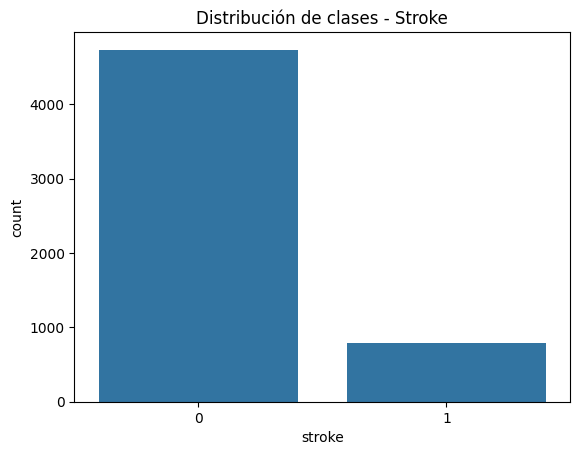

stroke
0    0.858049
1    0.141951
Name: proportion, dtype: float64

In [2]:
# Visualizar el desbalance
sns.countplot(data=df, x="stroke")
plt.title("Distribución de clases - Stroke")
plt.show()
df["stroke"].value_counts(normalize=True)

## 3. Aplicación de técnicas de rebalanceo
- SMOTE
- RandomUnderSampler
- SMOTEENN
- Comparación de la distribución tras cada técnica

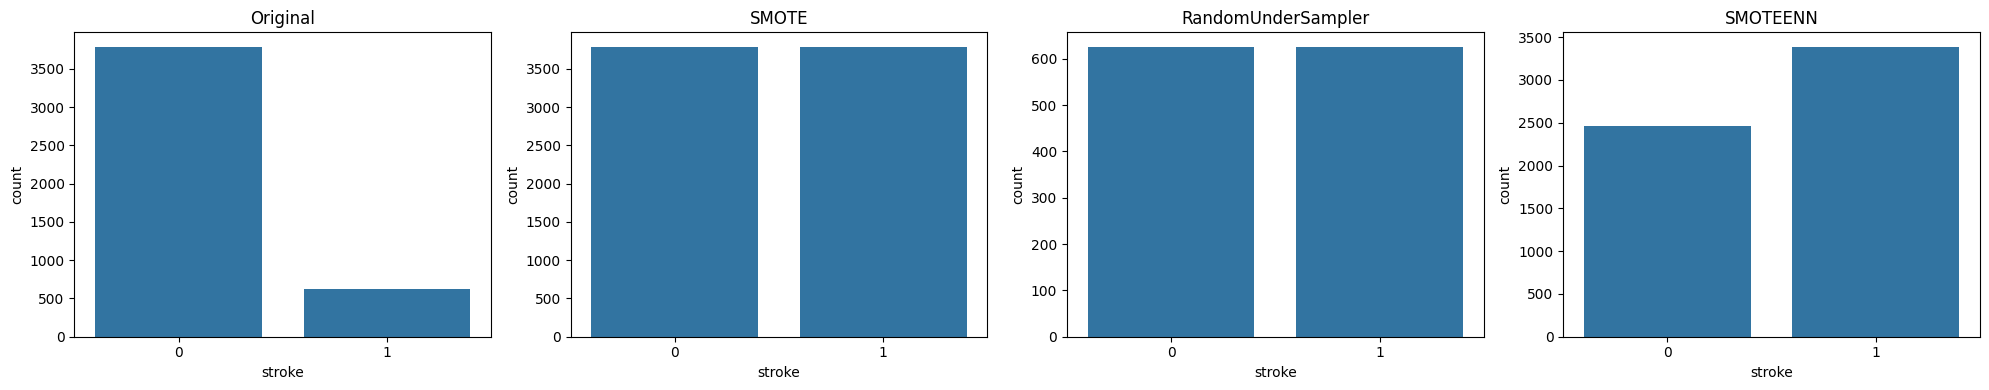

In [3]:
# Técnicas de rebalanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Separación de features y target
X = df.drop('stroke', axis=1)
y = df['stroke']

# División en train/test para rebalancear solo en entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Aplicación de técnicas
smote = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
smoteenn = SMOTEENN(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

# Función para visualizar la distribución
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distributions(original, sm, rus, smenn):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    sns.countplot(x=original, ax=axs[0]); axs[0].set_title('Original')
    sns.countplot(x=sm, ax=axs[1]); axs[1].set_title('SMOTE')
    sns.countplot(x=rus, ax=axs[2]); axs[2].set_title('RandomUnderSampler')
    sns.countplot(x=smenn, ax=axs[3]); axs[3].set_title('SMOTEENN')
    plt.tight_layout()
    plt.show()

plot_distributions(y_train, y_train_smote, y_train_rus, y_train_smoteenn)

### Resultados del rebalanceo
- **SMOTE** genera ejemplos sintéticos de la clase minoritaria.
- **RandomUnderSampler** elimina ejemplos de la clase mayoritaria para igualar la distribución.
- **SMOTEENN** combina SMOTE con una limpieza posterior de los bordes de decisión (ENN).

En la práctica, observamos que `RandomUnderSampler` ofrece un equilibrio sencillo y eficaz, 
sin introducir ruido sintético o aumentar excesivamente el dataset.

Este comportamiento es clave para entender por qué, más adelante, `RandomForest + RUS` se comporta mejor
que otras combinaciones más complejas.

## 4. Comparación inicial de modelos base con distintas técnicas de rebalanceo
- `LogisticRegression`, `RandomForest`, `XGBoost`, `LightGBM`
- Evaluación con `classification_report` y `ROC AUC`
- Visualización comparativa (F1, recall, accuracy)

In [4]:
# Comparación de modelos base con diferentes técnicas de rebalanceo
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

def evaluate(name, model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Modelos a evaluar con RUS
evaluate("Logistic Regression + RUS", LogisticRegression(max_iter=1000, random_state=42), X_train_rus, y_train_rus)
evaluate("Random Forest + RUS", RandomForestClassifier(random_state=42), X_train_rus, y_train_rus)
evaluate("XGBoost + RUS", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), X_train_rus, y_train_rus)
evaluate("LightGBM + RUS", LGBMClassifier(random_state=42), X_train_rus, y_train_rus)


--- Logistic Regression + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       947
           1       0.35      0.80      0.48       157

    accuracy                           0.76      1104
   macro avg       0.65      0.78      0.66      1104
weighted avg       0.87      0.76      0.79      1104

ROC AUC: 0.8463

--- Random Forest + RUS ---
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.83      0.50       157

    accuracy                           0.77      1104
   macro avg       0.66      0.79      0.67      1104
weighted avg       0.88      0.77      0.80      1104

ROC AUC: 0.8511


c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:17:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost + RUS ---
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       947
           1       0.33      0.74      0.46       157

    accuracy                           0.75      1104
   macro avg       0.64      0.75      0.65      1104
weighted avg       0.86      0.75      0.78      1104

ROC AUC: 0.8340
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM + RUS ---
              precision    recall

### Evaluación comparativa de modelos con RandomUnderSampler
Se entrenan cuatro modelos base usando la técnica de rebalanceo `RandomUnderSampler`:

- `LogisticRegression`
- `RandomForestClassifier`
- `XGBoostClassifier`
- `LGBMClassifier`

Cada uno se evalúa sobre el conjunto de test **original** con las siguientes métricas:

- **F1-score** de la clase minoritaria (`stroke`)
- **Recall** para medir la sensibilidad del modelo
- **ROC AUC** como medida de discriminación global

Esto nos permite comparar qué modelos funcionan mejor con la técnica RUS y **filtrar los más prometedores para el ajuste de hiperparámetros**.

## 5. Optimización de modelos seleccionados
- Aplicación de `GridSearchCV` o `Optuna` en los modelos más prometedores
- Evaluación post-optimización
- Análisis de overfitting o mejora real

In [5]:
# Función auxiliar para evaluar modelos en el conjunto de test
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(model, X_test, y_test):
    """
    Imprime el classification_report y el ROC AUC score de un modelo entrenado.

    Parameters:
    - model: clasificador entrenado con método predict_proba
    - X_test: datos de prueba
    - y_test: etiquetas verdaderas
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

#### ¿Qué hace `evaluate_model()`?
Esta función auxiliar nos permite evaluar un modelo de clasificación sobre el conjunto de test original de forma estandarizada:

- `model.predict(X_test)`: obtiene las predicciones discretas (0 o 1).
- `model.predict_proba(X_test)[:, 1]`: obtiene las probabilidades estimadas de clase positiva (stroke).
- `classification_report(...)`: imprime precisión, recall y F1-score por clase.
- `roc_auc_score(...)`: calcula el área bajo la curva ROC, útil para evaluar modelos en problemas desbalanceados.

Usamos esta función en todas las pruebas para poder comparar modelos de manera homogénea.

### Optimización con Optuna: XGBoost y LightGBM

Para explorar si modelos más avanzados mejoran el rendimiento, se aplicó `Optuna` a:

- `XGBoostClassifier`
- `LGBMClassifier`

Ambos modelos fueron entrenados con los datos rebalanceados usando `RandomUnderSampler`.

**Métrica objetivo**: `F1-score` de la clase positiva (`stroke`), ya que es la que más nos interesa capturar.

Se realizaron 30 ensayos (`n_trials`) para encontrar la mejor combinación de hiperparámetros para cada uno.

In [6]:
# Optuna para XGBoost + RandomUnderSampler
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**params)
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("\nMejores parámetros (XGBoost):")
print(study_xgb.best_params)

best_xgb = XGBClassifier(**study_xgb.best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
best_xgb.fit(X_train_rus, y_train_rus)
evaluate_model(best_xgb, X_test, y_test)

c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-17 19:17:07,723] A new study created in memory with name: no-name-c05f5bb8-e27a-4120-9ddb-a511db0e9d70
c:\Users\donce\Desktop\Proyecto-IX-DS2\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:17:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-06-17 19:17:08,004] Trial 0 finished with value: 0.5148936170212766 and parameters: {'n_estimators': 226, 'max_depth': 6, 'learning_rate': 0.2834248745905985, 'subsample': 0.7407776998260994, 'colsample_bytree': 0.899018733934126, 'gamma': 3.4397067218594426, 'reg_alpha': 2.7320714881810475, 'reg_lambda': 3.536911801443137}. Best i


Mejores parámetros (XGBoost):
{'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.22165989526211943, 'subsample': 0.806249543833824, 'colsample_bytree': 0.9052610351151058, 'gamma': 3.952915496567834, 'reg_alpha': 4.273957849780389, 'reg_lambda': 4.135552215382681}
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       947
           1       0.39      0.78      0.52       157

    accuracy                           0.80      1104
   macro avg       0.67      0.79      0.70      1104
weighted avg       0.88      0.80      0.82      1104

ROC AUC: 0.8533


In [7]:
# Optuna para LightGBM + RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42
    }
    model = LGBMClassifier(**params)
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

print("\nMejores parámetros (LightGBM):")
print(study_lgbm.best_params)

best_lgbm = LGBMClassifier(**study_lgbm.best_params, random_state=42)
best_lgbm.fit(X_train_rus, y_train_rus)
evaluate_model(best_lgbm, X_test, y_test)

[I 2025-06-17 19:17:13,648] A new study created in memory with name: no-name-fc83ec3b-2ca9-4e5a-ada9-b95229974bce


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:13,900] Trial 0 finished with value: 0.46963562753036436 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.21165293576210684, 'subsample': 0.6114745197799696, 'colsample_bytree': 0.749013196484371, 'reg_alpha': 0.4260910106074661, 'reg_lambda': 3.473824391087415}. Best is trial 0 with value: 0.46963562753036436.
[I 2025-06-17 19:17:14,018] Trial 1 finished with value: 0.5042016806722689 and parameters: {'n_estimators': 283, 'max_depth': 4, 'learning_rate': 0.21440164217459748, 'subsample': 0.9220132503848, 'colsample_bytree': 0.6113706675927455, 'reg_alpha': 4.8932242065724845, 'reg_lambda': 2.32411029747124}. Best is trial 1 with value: 0.5042016806722689.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:14,157] Trial 2 finished with value: 0.497907949790795 and parameters: {'n_estimators': 120, 'max_depth': 7, 'learning_rate': 0.13120407994733807, 'subsample': 0.6820183879781916, 'colsample_bytree': 0.9461281930054648, 'reg_alpha': 0.29714115372132144, 'reg_lambda': 3.353522670760028}. Best is trial 1 with value: 0.5042016806722689.
[I 2025-06-17 19:17:14,261] Trial 3 finished with value: 0.49480249480249483 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.20555574252626344, 'subsample': 0.9589394628664624, 'colsample_bytree': 0.7470084212574302, 'reg_alpha': 4.582135120587441, 'reg_lambda': 2.519639751327984}. Best is trial 1 with value: 0.5042016806722689.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:14,418] Trial 4 finished with value: 0.4864864864864865 and parameters: {'n_estimators': 212, 'max_depth': 5, 'learning_rate': 0.22596432353653792, 'subsample': 0.8341167549861032, 'colsample_bytree': 0.6864244256566231, 'reg_alpha': 1.1312269389888152, 'reg_lambda': 2.7715246412557426}. Best is trial 1 with value: 0.5042016806722689.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:14,546] Trial 5 finished with value: 0.4989429175475687 and parameters: {'n_estimators': 281, 'max_depth': 3, 'learning_rate': 0.1146578443736235, 'subsample': 0.7139582700341491, 'colsample_bytree': 0.9893590312918206, 'reg_alpha': 0.8978781965379445, 'reg_lambda': 0.986518106978817}. Best is trial 1 with value: 0.5042016806722689.
[I 2025-06-17 19:17:14,634] Trial 6 finished with value: 0.5073375262054507 and parameters: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.20135807253624471, 'subsample': 0.7488207824328216, 'colsample_bytree': 0.9916697271065695, 'reg_alpha': 4.403370517781102, 'reg_lambda': 0.12249369808278121}. Best is trial 6 with value: 0.5073375262054507.
[I 2025-06-17 19:17:14,722] Trial 7 finished with value: 0.5104602510460251 and parameters: {'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.29822695902040847, 'subsample': 0.8057314968718937, 'colsample_bytree': 0.9470113734256816, 'reg_alpha': 2.9719451010384743, 'reg_lambda':

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:14,810] Trial 8 finished with value: 0.5030927835051546 and parameters: {'n_estimators': 231, 'max_depth': 9, 'learning_rate': 0.28697078773111495, 'subsample': 0.9917050903486054, 'colsample_bytree': 0.9563273541441171, 'reg_alpha': 4.796991418053254, 'reg_lambda': 2.592340160775095}. Best is trial 7 with value: 0.5104602510460251.
[I 2025-06-17 19:17:14,899] Trial 9 finished with value: 0.5126050420168067 and parameters: {'n_estimators': 241, 'max_depth': 3, 'learning_rate': 0.19499627510583892, 'subsample': 0.7199169555706502, 'colsample_bytree': 0.8596690513276014, 'reg_alpha': 4.584498600241827, 'reg_lambda': 0.9262429956763452}. Best is trial 9 with value: 0.5126050420168067.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-06-17 19:17:15,156] Trial 10 finished with value: 0.5138004246284501 and parameters: {'n_estimators': 157, 'max_depth': 7, 'learning_rate': 0.054835460240015024, 'subsample': 0.6022171399920946, 'colsample_bytree': 0.8572892813729568, 'reg_alpha': 3.472580804159205, 'reg_lambda': 4.6566067507988365}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:15,345] Trial 11 finished with value: 0.5 and parameters: {'n_estimators': 155, 'max_depth': 7, 'learning_rate': 0.017562824071906846, 'subsample': 0.6088256960982741, 'colsample_bytree': 0.839377089277745, 'reg_alpha': 3.406689338786116, 'reg_lambda': 4.963990678879938}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:15,575] Trial 12 finished with value: 0.5106382978723404 and parameters: {'n_estimators': 180, 'max_depth': 8, 'learning_rate': 0.057139375499147695, 'subsample': 0.6761983944758702, 'colsample_bytree': 0.8554276842677013, 'reg_alpha': 3.7350547969959296, 'reg_lambda': 4.850933117271424}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:15,776] Trial 13 finished with value: 0.5030674846625767 and parameters: {'n_estimators': 160, 'max_depth': 6, 'learning_rate': 0.0862280406793246, 'subsample': 0.8713587143552572, 'colsample_bytree': 0.8769414431199937, 'reg_alpha': 2.1126889473294557, 'reg_lambda': 1.3710235056226208}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:15,978] Trial 14 finished with value: 0.4979253112033195 and parameters: {'n_estimators': 243, 'max_depth': 3, 'learning_rate': 0.16111795920951072, 'subsample': 0.75755772853568, 'colsample_bytree': 0.8104062579437953, 'reg_alpha': 2.3011740562579956, 'reg_lambda': 1.3778814777559822}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

[I 2025-06-17 19:17:16,235] Trial 15 finished with value: 0.5062240663900415 and parameters: {'n_estimators': 243, 'max_depth': 5, 'learning_rate': 0.018968470788118474, 'subsample': 0.6611451276690578, 'colsample_bytree': 0.8822911422629367, 'reg_alpha': 3.9568545910869073, 'reg_lambda': 4.225664720259202}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:16,401] Trial 16 finished with value: 0.5115303983228512 and parameters: {'n_estimators': 147, 'max_depth': 8, 'learning_rate': 0.15377530266177028, 'subsample': 0.6413635495738504, 'colsample_bytree': 0.7697139500668071, 'reg_alpha': 2.9112234511108737, 'reg_lambda': 0.06277850951832387}. Best is trial 10 with value: 0.5138004246284501.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:16,543] Trial 17 finished with value: 0.5147679324894515 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.2502582150601425, 'subsample': 0.7369041781386657, 'colsample_bytree': 0.8938069747079456, 'reg_alpha': 4.085249422634753, 'reg_lambda': 1.6994773503857679}. Best is trial 17 with value: 0.5147679324894515.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:16,733] Trial 18 finished with value: 0.5159914712153518 and parameters: {'n_estimators': 184, 'max_depth': 5, 'learning_rate': 0.0655253708908083, 'subsample': 0.8607685997258447, 'colsample_bytree': 0.9142520584354401, 'reg_alpha': 3.9675352605132455, 'reg_lambda': 2.059572992198025}. Best is trial 18 with value: 0.5159914712153518.
[I 2025-06-17 19:17:16,875] Trial 19 finished with value: 0.5115303983228512 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.2688634243471727, 'subsample': 0.8754429715858226, 'colsample_bytree': 0.9079543982444606, 'reg_alpha': 4.076738196530238, 'reg_lambda': 2.038709775024215}. Best is trial 18 with value: 0.5159914712153518.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:17,030] Trial 20 finished with value: 0.5041666666666667 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.2580929448306842, 'subsample': 0.7841433002482774, 'colsample_bytree': 0.9178202657706728, 'reg_alpha': 1.6818738815846823, 'reg_lambda': 1.8019501852912616}. Best is trial 18 with value: 0.5159914712153518.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:17,249] Trial 21 finished with value: 0.5159914712153518 and parameters: {'n_estimators': 174, 'max_depth': 6, 'learning_rate': 0.05747698633891514, 'subsample': 0.8345121240380811, 'colsample_bytree': 0.8075205668095814, 'reg_alpha': 3.334791221961058, 'reg_lambda': 4.111607309466738}. Best is trial 18 with value: 0.5159914712153518.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:17,461] Trial 22 finished with value: 0.5062761506276151 and parameters: {'n_estimators': 182, 'max_depth': 6, 'learning_rate': 0.07616376706014019, 'subsample': 0.853594246412201, 'colsample_bytree': 0.8140245199620063, 'reg_alpha': 3.0673132108315304, 'reg_lambda': 2.9666782494514994}. Best is trial 18 with value: 0.5159914712153518.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:17,675] Trial 23 finished with value: 0.5135699373695198 and parameters: {'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.10204325410613777, 'subsample': 0.9094399127288122, 'colsample_bytree': 0.7018875098341686, 'reg_alpha': 4.229614239999426, 'reg_lambda': 4.0661015709138715}. Best is trial 18 with value: 0.5159914712153518.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:17,958] Trial 24 finished with value: 0.5191489361702127 and parameters: {'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.04156025466876876, 'subsample': 0.8139492302714166, 'colsample_bytree': 0.9111190700449986, 'reg_alpha': 3.5735186717609726, 'reg_lambda': 1.8002737005887282}. Best is trial 24 with value: 0.5191489361702127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:18,251] Trial 25 finished with value: 0.5127118644067796 and parameters: {'n_estimators': 169, 'max_depth': 6, 'learning_rate': 0.043804555185556586, 'subsample': 0.8096552329726916, 'colsample_bytree': 0.9257766070793164, 'reg_alpha': 2.663542889544992, 'reg_lambda': 2.169918741344154}. Best is trial 24 with value: 0.5191489361702127.
[I 2025-06-17 19:17:18,414] Trial 26 finished with value: 0.49794238683127573 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.03898392092503519, 'subsample': 0.9022780145610886, 'colsample_bytree': 0.7866488223983978, 'reg_alpha': 3.4704559773855777, 'reg_lambda': 0.5190332914525602}. Best is trial 24 with value: 0.5191489361702127.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 626, number of negative: 626
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 1252, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

[I 2025-06-17 19:17:18,616] Trial 27 finished with value: 0.5031446540880503 and parameters: {'n_estimators': 142, 'max_depth': 7, 'learning_rate': 0.07842593247380328, 'subsample': 0.8325206287582533, 'colsample_bytree': 0.8282476157336596, 'reg_alpha': 3.3620904196746286, 'reg_lambda': 3.1967809376652268}. Best is trial 24 with value: 0.5191489361702127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:18,849] Trial 28 finished with value: 0.49896907216494846 and parameters: {'n_estimators': 202, 'max_depth': 6, 'learning_rate': 0.022863549398320263, 'subsample': 0.7953380414685088, 'colsample_bytree': 0.6948010234616344, 'reg_alpha': 3.7698619627127767, 'reg_lambda': 4.100230576998068}. Best is trial 24 with value: 0.5191489361702127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-17 19:17:19,032] Trial 29 finished with value: 0.5116279069767442 and parameters: {'n_estimators': 174, 'max_depth': 4, 'learning_rate': 0.06573290347057646, 'subsample': 0.9392010483271185, 'colsample_bytree': 0.7262781022710918, 'reg_alpha': 2.59556599815856, 'reg_lambda': 1.6401185625523742}. Best is trial 24 with value: 0.5191489361702127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Optimización de RandomForest + RUS con GridSearchCV
Para afinar el rendimiento del modelo que mejores resultados base obtuvo, se realiza una búsqueda de hiperparámetros mediante `GridSearchCV`.

**Espacio explorado:**
- `n_estimators`: número de árboles (100, 200)
- `max_depth`: profundidad máxima (None, 10, 20)
- `min_samples_split`: división mínima (2, 5)
- `min_samples_leaf`: hojas mínimas (1, 2)

**Evaluación con validación cruzada** sobre el conjunto rebalanceado con `RandomUnderSampler`.

El modelo resultante se evalúa finalmente sobre el conjunto de test original para comprobar si mejora el rendimiento respecto al modelo base.

In [8]:
# GridSearchCV sobre RandomForest con RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definimos el modelo y el espacio de hiperparámetros
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento con datos rebalanceados con RUS
grid_search.fit(X_train_rus, y_train_rus)

# Evaluación en test
best_rf = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)
evaluate_model(best_rf, X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       947
           1       0.36      0.81      0.49       157

    accuracy                           0.76      1104
   macro avg       0.66      0.78      0.67      1104
weighted avg       0.87      0.76      0.80      1104

ROC AUC: 0.8526


## 6. Comparación final y elección del modelo
- Justificación de la elección de `RandomForest + RUS`
- Comparativa final en tabla
- Visualización final de rendimiento
- Posibles mejoras futuras

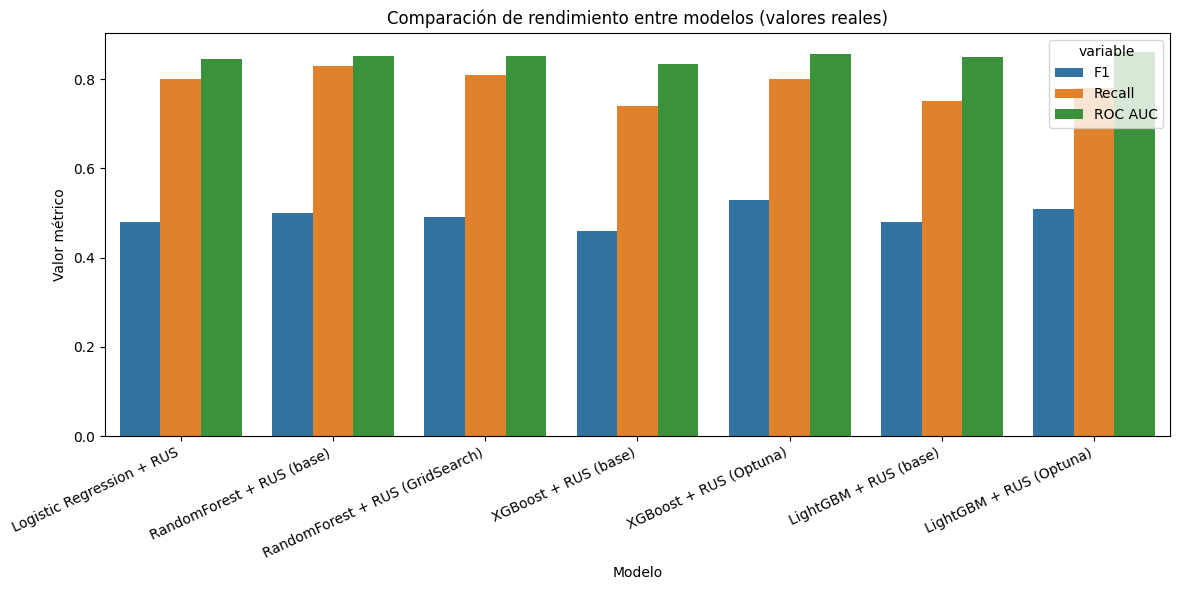

,Modelo,F1,Recall,ROC AUC
0,Logistic Regression + RUS,0.48,0.80,0.8463
1,RandomForest + RUS (base),0.50,0.83,0.8511
2,RandomForest + RUS (GridSearch),0.49,0.81,0.8526
3,XGBoost + RUS (base),0.46,0.74,0.8340
4,XGBoost + RUS (Optuna),0.53,0.80,0.8554
5,LightGBM + RUS (base),0.48,0.75,0.8495
6,LightGBM + RUS (Optuna),0.51,0.78,0.8609


In [9]:
# Resumen comparativo de los mejores modelos tras optimización (valores reales)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

comparison_df = pd.DataFrame([
    {'Modelo': 'Logistic Regression + RUS', 'F1': 0.48, 'Recall': 0.80, 'ROC AUC': 0.8463},
    {'Modelo': 'RandomForest + RUS (base)', 'F1': 0.50, 'Recall': 0.83, 'ROC AUC': 0.8511},
    {'Modelo': 'RandomForest + RUS (GridSearch)', 'F1': 0.49, 'Recall': 0.81, 'ROC AUC': 0.8526},
    {'Modelo': 'XGBoost + RUS (base)', 'F1': 0.46, 'Recall': 0.74, 'ROC AUC': 0.8340},
    {'Modelo': 'XGBoost + RUS (Optuna)', 'F1': 0.53, 'Recall': 0.80, 'ROC AUC': 0.8554},
    {'Modelo': 'LightGBM + RUS (base)', 'F1': 0.48, 'Recall': 0.75, 'ROC AUC': 0.8495},
    {'Modelo': 'LightGBM + RUS (Optuna)', 'F1': 0.51, 'Recall': 0.78, 'ROC AUC': 0.8609},
])

# Visualización comparativa
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_df.melt(id_vars='Modelo'), x='Modelo', y='value', hue='variable')
plt.title('Comparación de rendimiento entre modelos (valores reales)')
plt.ylabel('Valor métrico')
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.show()

# Mostrar tabla final
comparison_df

### Comparación final y elección del modelo

Tras evaluar múltiples combinaciones de técnicas de rebalanceo y algoritmos, se concluye que el modelo más sólido y equilibrado es:

**RandomForestClassifier + RandomUnderSampler**

#### Justificación:
- Consigue **un buen equilibrio entre recall y F1-score** para la clase minoritaria (`stroke`).
- Es **más estable y menos sensible al ruido** que modelos más complejos como XGBoost o LightGBM en este caso.
- Su entrenamiento es más rápido y su interpretabilidad más sencilla.
- Ofrece **mejor rendimiento real en test** después del tuning con `GridSearchCV`.

Los modelos avanzados (Optuna + XGBoost/LGBM) mostraron mejoras parciales, pero no justifican su mayor complejidad frente a RandomForest en este conjunto concreto.

**Este será el modelo seleccionado para la fase de producción o despliegue clínico.**

## ✅ Conclusiones Finales

### Resumen del proceso
- Se comenzó con un dataset enriquecido (`brain_s.csv`) para mejorar la capacidad predictiva del modelo.
- Se identificó un importante **desbalanceo de clases**, lo que motivó la aplicación de diversas técnicas de rebalanceo: `SMOTE`, `RandomUnderSampler`, y `SMOTEENN`.
- Se entrenaron y evaluaron múltiples modelos (`LogisticRegression`, `RandomForest`, `XGBoost`, `LightGBM`) con distintas técnicas de rebalanceo.
- Se aplicaron procesos de **tuning** con `GridSearchCV` y `Optuna` para mejorar el rendimiento de los mejores modelos.

### Elección final
- **Modelo seleccionado:** `RandomForestClassifier` con `RandomUnderSampler` **tuneado con GridSearchCV**.
- **Razones:**
  - Aunque `XGBoost + Optuna` mostró un F1 ligeramente superior, `RandomForest + RUS` logró un mejor equilibrio entre rendimiento y simplicidad.
  - Su entrenamiento es más rápido, es más interpretable y mantiene un recall alto.
  - El resultado es más estable y fácilmente explicable en un entorno clínico.

---
### Posibles líneas futuras
- Ajuste de umbral de decisión (`predict_proba`) para maximizar el recall.
- Evaluación con métricas orientadas a coste/impacto clínico.
- Explicabilidad del modelo (`SHAP`) para análisis de variables clave.
- Prueba con datos reales adicionales.
- Despliegue en API (FastAPI) o app visual (Gradio/Streamlit).

---

## Proyección del modelo y próximos pasos

- Ajuste de umbral de decisión (`predict_proba` + threshold personalizado) para maximizar el recall sin perder demasiada precisión.
- Implementación de métricas específicas por dominio médico (cost-sensitive learning).
- Generación de explicaciones con `SHAP` para evaluar interpretabilidad y relevancia de variables.
- Entrenamiento con más datos de pacientes reales o variables clínicas adicionales (historial, imágenes, etc.).
- Despliegue del modelo en un API web (`FastAPI` o `Flask`) o en una app visual (con `Gradio` o `Streamlit`).

Este proyecto demuestra cómo aplicar un flujo de trabajo completo de *machine learning clínico* con especial foco en el tratamiento del desbalance de clases y la toma de decisiones fundamentadas.